<a href="https://colab.research.google.com/github/Jair-RM/Modelacion-Financiera/blob/main/OC_SMF_Acciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Manejo de Acciones

**Oliver Cuate**

*28 de febrero de 2025*

---

En este cuaderno le mostraré cómo usar [Pymoo](https://pymoo.org/) para resolver el problema clásico de portafolios (2 acciones).

## Obtener precios de acciones

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

hoy = pd.Timestamp.today()
inicio = hoy - pd.Timedelta(days=365*5)

print(inicio, hoy)

#tickers = ["^MXX", "BIMBOA.MX"]     # IPC MEXICO, BIMBO
tickers = ["CEMEXCPO.MX", "BIMBOA.MX"]     # CEMEX, BIMBO

# inicio.strftime('%Y-%m-%d') # por si hay error
#datos = yf.download(ticker, start=inicio, end=hoy).copy() # todos los datos

datos = yf.download(tickers, start=inicio, end=hoy)['Close'].copy() # todos los datos

2020-03-01 05:19:07.154103 2025-02-28 05:19:07.154103
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed


Vemos los datos

In [ ]:
datos

Ticker,BIMBOA.MX,CEMEXCPO.MX
Date,,
2020-03-02,28.488962,6.406640
2020-03-03,28.784565,6.586546
2020-03-04,29.579006,6.726472
2020-03-05,28.581341,6.256719
2020-03-06,27.620619,5.876918
...,...,...
2025-02-21,56.259998,13.350000
2025-02-24,56.590000,13.110000
2025-02-25,56.490002,13.200000


## Calculamos los rendimientos

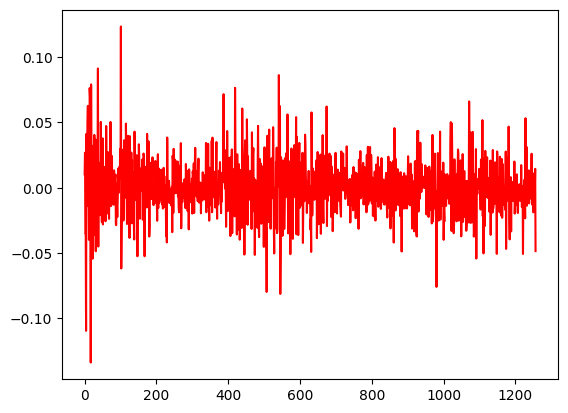

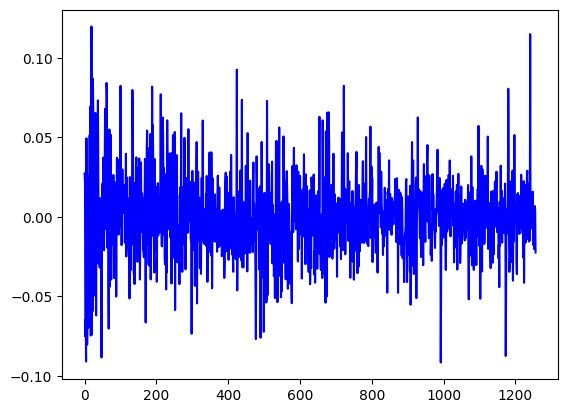

In [ ]:
rend = (datos.values[1:]-datos.values[0:-1])/datos.values[1:]

plt.plot(range(rend.shape[0]),rend[:,0],'r')
plt.show()

plt.plot(range(rend.shape[0]),rend[:,1],'b')
plt.show()

In [ ]:
r = rend.mean(axis=0)
r

array([0.00028995, 0.00023228])

In [ ]:
Cov = np.cov(rend, rowvar=False)
Cov

array([[0.00045618, 0.00012247],
       [0.00012247, 0.00065321]])

## Uso de Pymoo

Primero, hay que instalar Pymoo

In [ ]:
!pip install -U pymoo

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       50 |      3 |  0.000000E+00 |  0.2551687336 |             - |             -
     2 |      100 |      9 |  0.000000E+00 |  0.0199360800 |  0.0670367667 |         ideal
     3 |      150 |     18 |  0.000000E+00 |  0.000000E+00 |  0.1344887220 |         ideal
     4 |      200 |     22 |  0.000000E+00 |  0.000000E+00 |  0.0705819630 |         ideal
     5 |      250 |     30 |  0.000000E+00 |  0.000000E+00 |  0.0051198939 |         ideal
     6 |      300 |     36 |  0.000000E+00 |  0.000000E+00 |  0.0890356274 |         ideal
     7 |      350 |     44 |  0.000000E+00 |  0.000000E+00 |  0.0034927207 |             f
     8 |      400 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0428455852 |         ideal
     9 |      450 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0037098850 |             f
    10 |      500 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0091262054 |         ideal

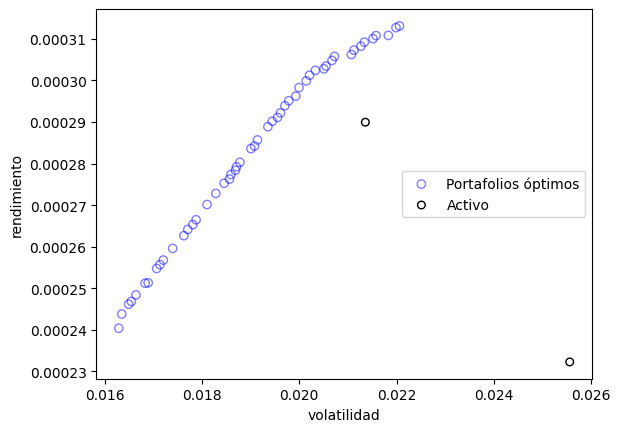

In [ ]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

class Portafolio(Problem):
  def __init__(self, mu, cov):
    self.mu = mu
    self.cov = cov
    super().__init__(n_var=2, n_obj=2, n_ieq_constr=1, xl=0.0, xu=1.0)

  def _evaluate(self, x, out, *args, **kwargs):
    rendimiento = x @ self.mu
    riesgo = np.zeros(x.shape[0])
    for (i,w) in enumerate(x):
      riesgo[i] = np.sqrt(w @ self.cov @ w.T)

    out["F"] = [riesgo, -rendimiento]
    out["G"] = np.abs( np.sum(x, axis=1) - 1.0 ) - 0.1

problem = Portafolio(r,Cov)

algorithm = NSGA2(pop_size=50)

res = minimize(problem,
               algorithm,
               ('n_gen', 200),
               seed=1,
               verbose=True)


X, F = res.opt.get("X", "F")
F = F * [1, -1]

plt.scatter(F[:, 0], F[:, 1], facecolor="none", edgecolors="blue", alpha=0.5, label="Portafolios óptimos")
plt.scatter(Cov.diagonal() ** 0.5, r, facecolor="none", edgecolors="black", s=30, label="Activo")
#plt.legend(loc='best')
plt.legend(loc=7)
plt.xlabel("volatilidad")
plt.ylabel("rendimiento")
plt.show()

In [ ]:
np.sum( res.X, axis=1 )

array([1.09998446, 0.900319  , 1.06116306, 0.90059901, 1.02895151,
       0.91342006, 1.04420042, 0.93438702, 1.08936168, 0.93263802,
       0.92081917, 1.04847974, 0.90372643, 1.07453687, 1.09823973,
       1.08819822, 1.08394975, 1.09997225, 1.09809956, 0.94134033,
       1.09988565, 1.06403296, 1.06672424, 1.09470528, 1.09758595,
       1.09376329, 1.09829956, 1.01529828, 0.98518198, 1.09581076,
       1.05860582, 0.90213941, 1.09235936, 0.99831303, 0.99444297,
       1.0905674 , 1.09934963, 1.02455912, 1.09357378, 1.08988911,
       0.97414079, 0.9415904 , 1.02315168, 1.05210605, 1.09953999,
       0.94993611, 1.01364555, 0.96588094, 0.97170222, 1.02582371])

[Posición de la etiqueta](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html)